## Remap Series 2: Plor clusters

In [62]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)


In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
from spyglass.decoding.clusterless import UnitMarksIndicator

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[2023-09-28 15:28:21,353][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
28-Sep-23 15:28:21 Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-09-28 15:28:21,379][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
28-Sep-23 15:28:21 Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters im

### Pick a day in the next cell.

In [4]:
nwb_copy_file_name = "eliot20221022_.nwb"

In [5]:
tetrodes = np.unique((UnitMarksIndicator & {"nwb_file_name": nwb_copy_file_name}).fetch('sort_group_id'))
print(tetrodes)

[ 0  2  4  5 13 14 16 17 20 23 26 27 28 29 30 31]


In [53]:
from spyglass.spikesorting import SpikeSorting

In [64]:
SpikeSorting & {"nwb_file_name": nwb_copy_file_name,
                "sort_interval_name":"02_Seq2Session1",
                "sorter":'mountainsort4',"sort_group_id":14}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_3d6dc36c_spikesorting,1695950048


### UnitMarksIndicator

The first thing we need are the marks indicators for the clusterless decoding. See the `Extract_Mark_indicators.ipynb` for information on how to populate this table. We will use the special method `fetch_xarray` to get a labeled array of shape (n_time, n_mark_features, n_electrodes). Time will be in 2 ms bins, where it will be NaN if no spike occurs and the value of the spike features if a spike occured.

If more than one spike is in a single time bin from a single tetrode, we just average the marks. Technically this isn't ideal, we should use all the marks, but it doesn't seem to happen that often and the decodes seem robust to it.

The UnitMarksIndicator table depends on an interval from the interval list and a sampling rate.

In [6]:
import pandas as pd

UnitMarksIndicator & {"nwb_file_name": nwb_copy_file_name} & {"sort_group_id": tetrodes[0]}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate,analysis_file_name name of the file,marks_indicator_object_id
0,eliot20221022_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 1 valid times,500.0,eliot20221022_NPMAFRHXF0.nwb,ffafdeff-d7d4-482a-91b1-a2601ecd2900
0,eliot20221022_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 3 valid times,500.0,eliot20221022_LWXUJS6X1J.nwb,3b6ea383-304b-4526-be2c-b05bb9c16318
0,eliot20221022_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 5 valid times,500.0,eliot20221022_A40XQF77VJ.nwb,d06efc37-7a83-478b-99a7-d6bbd55127cc
0,eliot20221022_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 7 valid times,500.0,eliot20221022_IUBD181FC2.nwb,8c369f76-6178-47dd-be09-7fea48c0f40e
0,eliot20221022_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 9 valid times,500.0,eliot20221022_O8Z1MHL5DI.nwb,87ec8420-e84e-477a-ac3d-52b4ca104655


In [7]:
sessions=(UnitMarksIndicator & {"nwb_file_name": nwb_copy_file_name} & {"sort_group_id": tetrodes[0]}).fetch('sort_interval_name')
print(sessions)

['06_Seq2Session3' '08_Seq2Session4' '04_Seq2Session2' '02_Seq2Session1'
 '10_Seq2Session5']


In [8]:
session1 = sessions[0]
session2 = sessions[1]
sort_group_id = 14

### Process the marks

In [9]:
import pandas as pd
from spyglass.decoding.clusterless import UnitMarksIndicator

def get_marks(sort_group_id, sort_interval_name):
    marks = (
        UnitMarksIndicator
        & {
            "nwb_file_name": nwb_copy_file_name,
            "sort_interval_name": sort_interval_name,
            "sort_group_id": sort_group_id,
            #"filter_parameter_set_name": "franklab_default_hippocampus",
            #"unit_inclusion_param_name": "all2",
            #"mark_param_name": "default",
            #"interval_list_name": "pos 3 valid times",
            "sampling_rate": 500,
        }
    ).fetch_xarray()
    return marks


### Get x and y for each interval

In [10]:
def data_set(sort_group_id, sort_interval_name):
    marks = get_marks(sort_group_id, sort_interval_name)
    electrode_ind = marks.electrodes
    m = marks.sel(electrodes=electrode_ind).dropna("time", how="all").dropna("marks")
    ax_ind=[]
    feature=[]
    for ax_ind1, feature1 in enumerate(m.marks):
        ax_ind.append(ax_ind1)
        feature.append(feature1)
    pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
    x_list = []
    y_list = []
    for i in range(6):
        x = marks.sel(marks=feature[pair[i][0]])
        x_list.append(x)
        y = marks.sel(marks=feature[pair[i][1]])
        y_list.append(y)
    return x_list, y_list    

### Refresh

In [11]:
x_list_1, y_list_1 = data_set (sort_group_id, session1)
x_list_2, y_list_2 = data_set (sort_group_id, session2)

[2023-09-28 15:28:35,547][WARNING]: Skipped checksum for file with hash: bfab1d10-a44a-2a23-8cd1-348f4a799aef, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GCMVSC20FF.nwb
28-Sep-23 15:28:35 Skipped checksum for file with hash: bfab1d10-a44a-2a23-8cd1-348f4a799aef, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GCMVSC20FF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is depre

### Scatter Density Plot

In [12]:
import mpl_scatter_density
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
redmap= LinearSegmentedColormap.from_list('redmap', [
    (0, '#ffffff'),
    (1e-20, '#FF2D00'),
    (0.2, '#D72600'),
    (0.4, '#B42000'),
    (0.6, '#911A00'),
    (0.8, '#751500'),
    (1, '#5D1100'),
], N=256)

bluemap= LinearSegmentedColormap.from_list('bluemap', [
    (0, '#ffffff'),
    (1e-20, '#0042FF'),
    (0.2, '#0138D3'),
    (0.4, '#012CA5'),
    (0.6, '#012280'),
    (0.8, '#00185D'),
    (1, '#001244'),
], N=256)

Plot one pair of electrode

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/shijiegu/anaconda3/envs/spyglass/lib/pytho

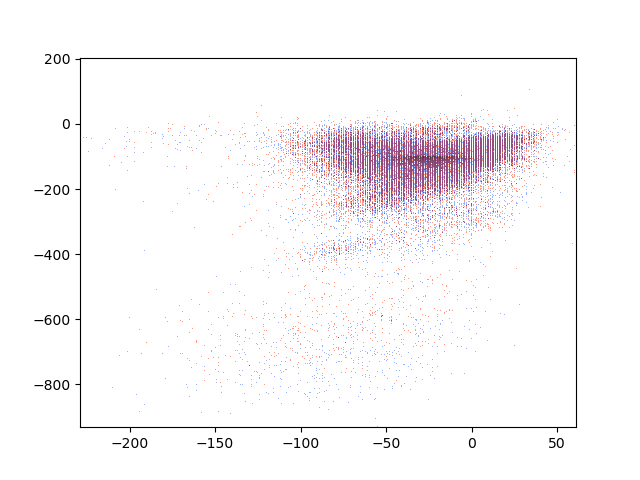

In [13]:
def plot_density_one(i):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    ax.scatter_density(x_list_1[i], y_list_1[i], cmap=redmap,dpi=100,alpha = 0.8)
    ax.scatter_density(x_list_2[i], y_list_2[i], cmap=bluemap,dpi=100,alpha = 0.4)
    plt.show()
plot_density_one(0)

Plot for all pairs of electrodes

In [14]:
from mpl_toolkits.mplot3d import Axes3D

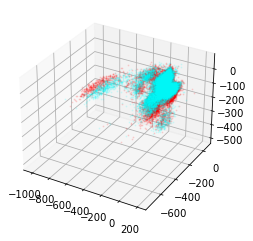

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i=4
j=5
ax.scatter(x_list_1[i], x_list_1[j], y_list_1[i], c='cyan', s=1,alpha = 0.1,depthshade=0)
ax.scatter(x_list_2[i], x_list_2[j], y_list_2[i], c='r', s=1,alpha = 0.1,depthshade=0)

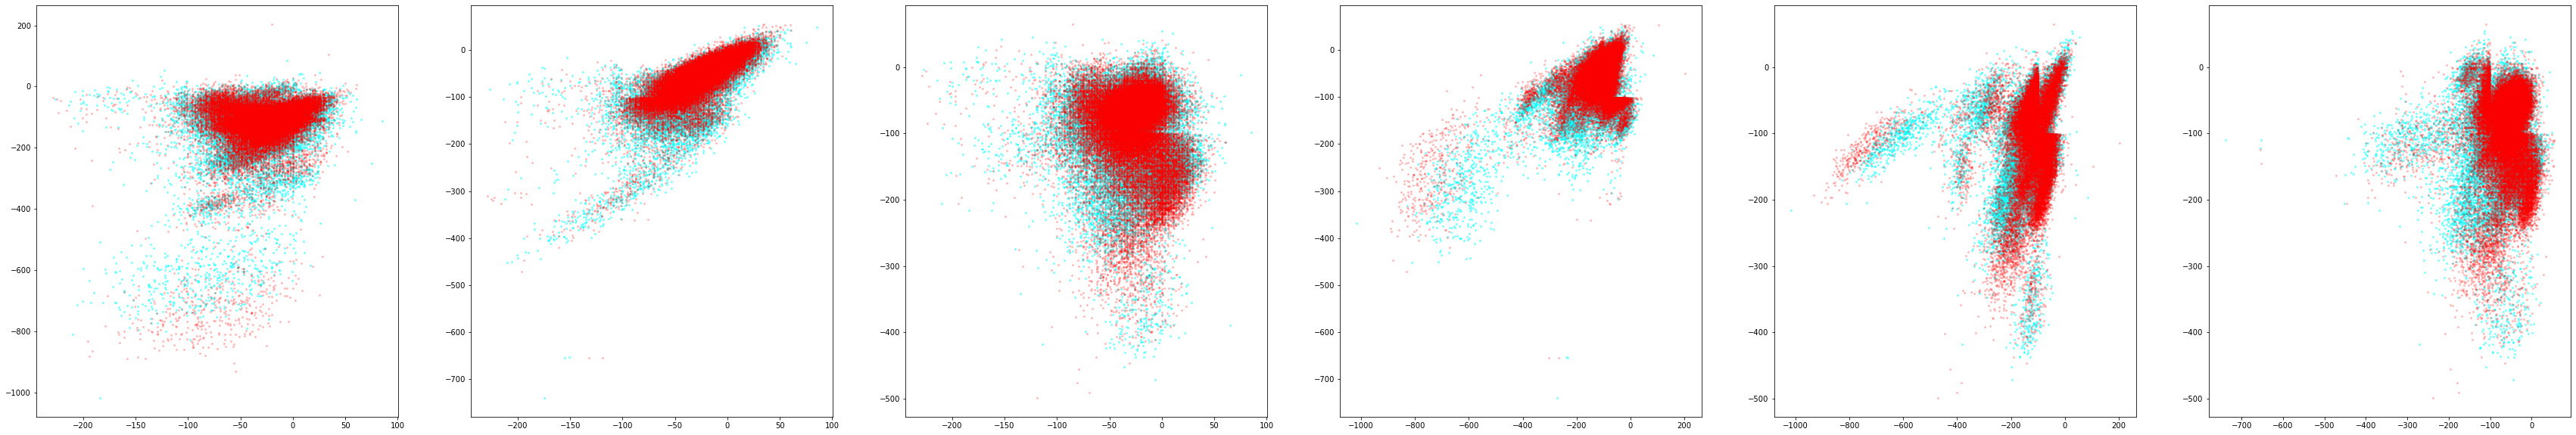

In [32]:
def plot_density_all():
    fig = plt.figure(figsize = (60,10))
    #ax.scatter_density(x, y, cmap=redmap, alpha = 0.5)
    axes = [0,0,0,0,0,0]
    for i in range(6):
        axes[i] = fig.add_subplot(1, 6, i+1)
        axes[i].scatter(x_list_1[i], y_list_1[i], c='cyan', s=4,alpha = 0.4)
        axes[i].scatter(x_list_2[i], y_list_2[i], c='r', s=4,alpha = 0.2)
    plt.show()
%matplotlib inline
plot_density_all()

### Not Good
Transparent scatter with different color 

In [24]:
def plot_spray_window(sort_group_id, sort_interval_name_list):
    #The subplot
    pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
    #ax_pair=[[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
    plot_size=20
    fig, axes = plt.subplots(1,6,
                    constrained_layout=True,
                    sharex=True,
                    sharey=True,
                    figsize=(plot_size * 6, plot_size * 1),
                )    
    for sort_interval_name in sort_interval_name_list:
        marks = get_marks(sort_group_id, sort_interval_name)
        electrode_ind = marks.electrodes
        m = marks.sel(electrodes=electrode_ind).dropna("time", how="all").dropna("marks")
        ax_ind=[]
        feature=[]
        for ax_ind1, feature1 in enumerate(m.marks):
            ax_ind.append(ax_ind1)
            feature.append(feature1)

        for i in range(6):
            axes[i].scatter(marks.sel(marks=feature[pair[i][0]]),marks.sel(marks=feature[pair[i][1]]),s=2,alpha = 0.05)
            #axes[i].set_aspect('equal', adjustable='box')
    return fig, axes

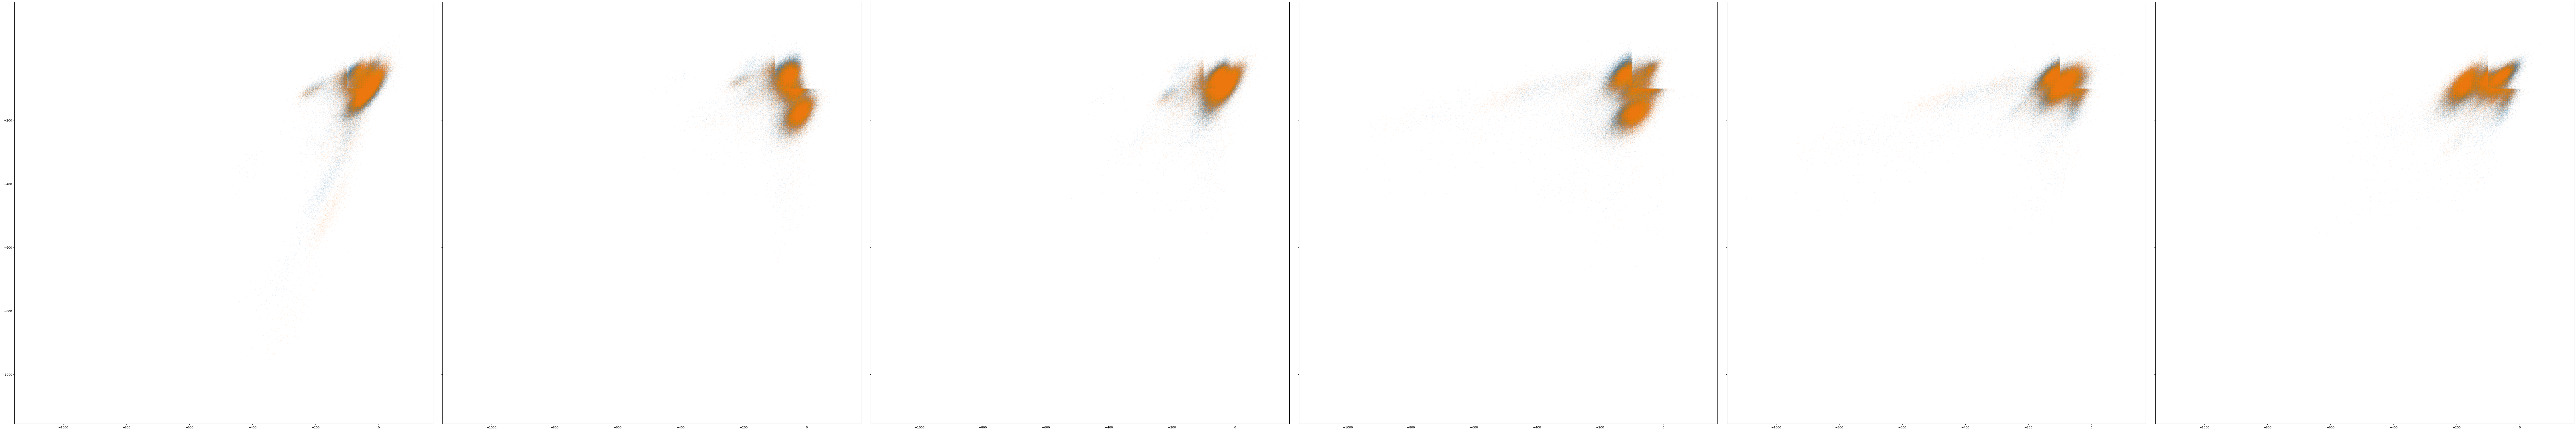

In [25]:
sort_interval_name_list = ["02_Seq2Session1", "04_Seq2Session2"]
fig, ax = plot_spray_window(13, sort_interval_name_list)
#plot_spray_window(13, "04_Seq2Session2")


Not working

(-0.5, 639.5, 479.5, -0.5)

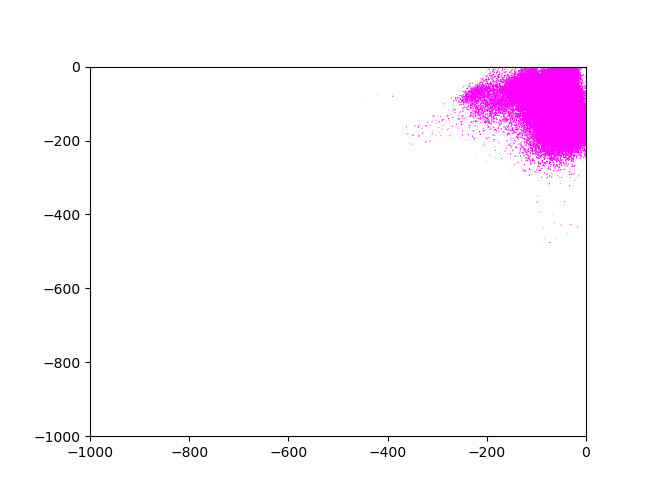

In [102]:
i = 1
fig, ax = plt.subplots()
ax.scatter(x_list_1[i],y_list_1[i],c='b',edgecolors='none', s=1)
ax.set_xlim(-1000,0)
ax.set_ylim(-1000,0)
ax.patch.set_facecolor("none")
ax.patch.set_edgecolor("none")
fig.canvas.draw()

w, h = fig.canvas.get_width_height()
img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1).copy()

ax.clear()
ax.scatter(x_list_2[i], y_list_2[i], c='r',edgecolors='none', s=1)
ax.set_xlim(-1000,0)
ax.set_ylim(-1000,0)
ax.patch.set_facecolor("none")
ax.patch.set_edgecolor("none")
fig.canvas.draw()

img2 = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1).copy()

img[img[:, :, -1] == 0] = 0
img2[img2[:, :, -1] == 0] = 0

fig.clf()

plt.imshow(np.maximum(img, img2))
plt.subplots_adjust(0, 0, 1, 1)
plt.axis("off")

### Plot all marks

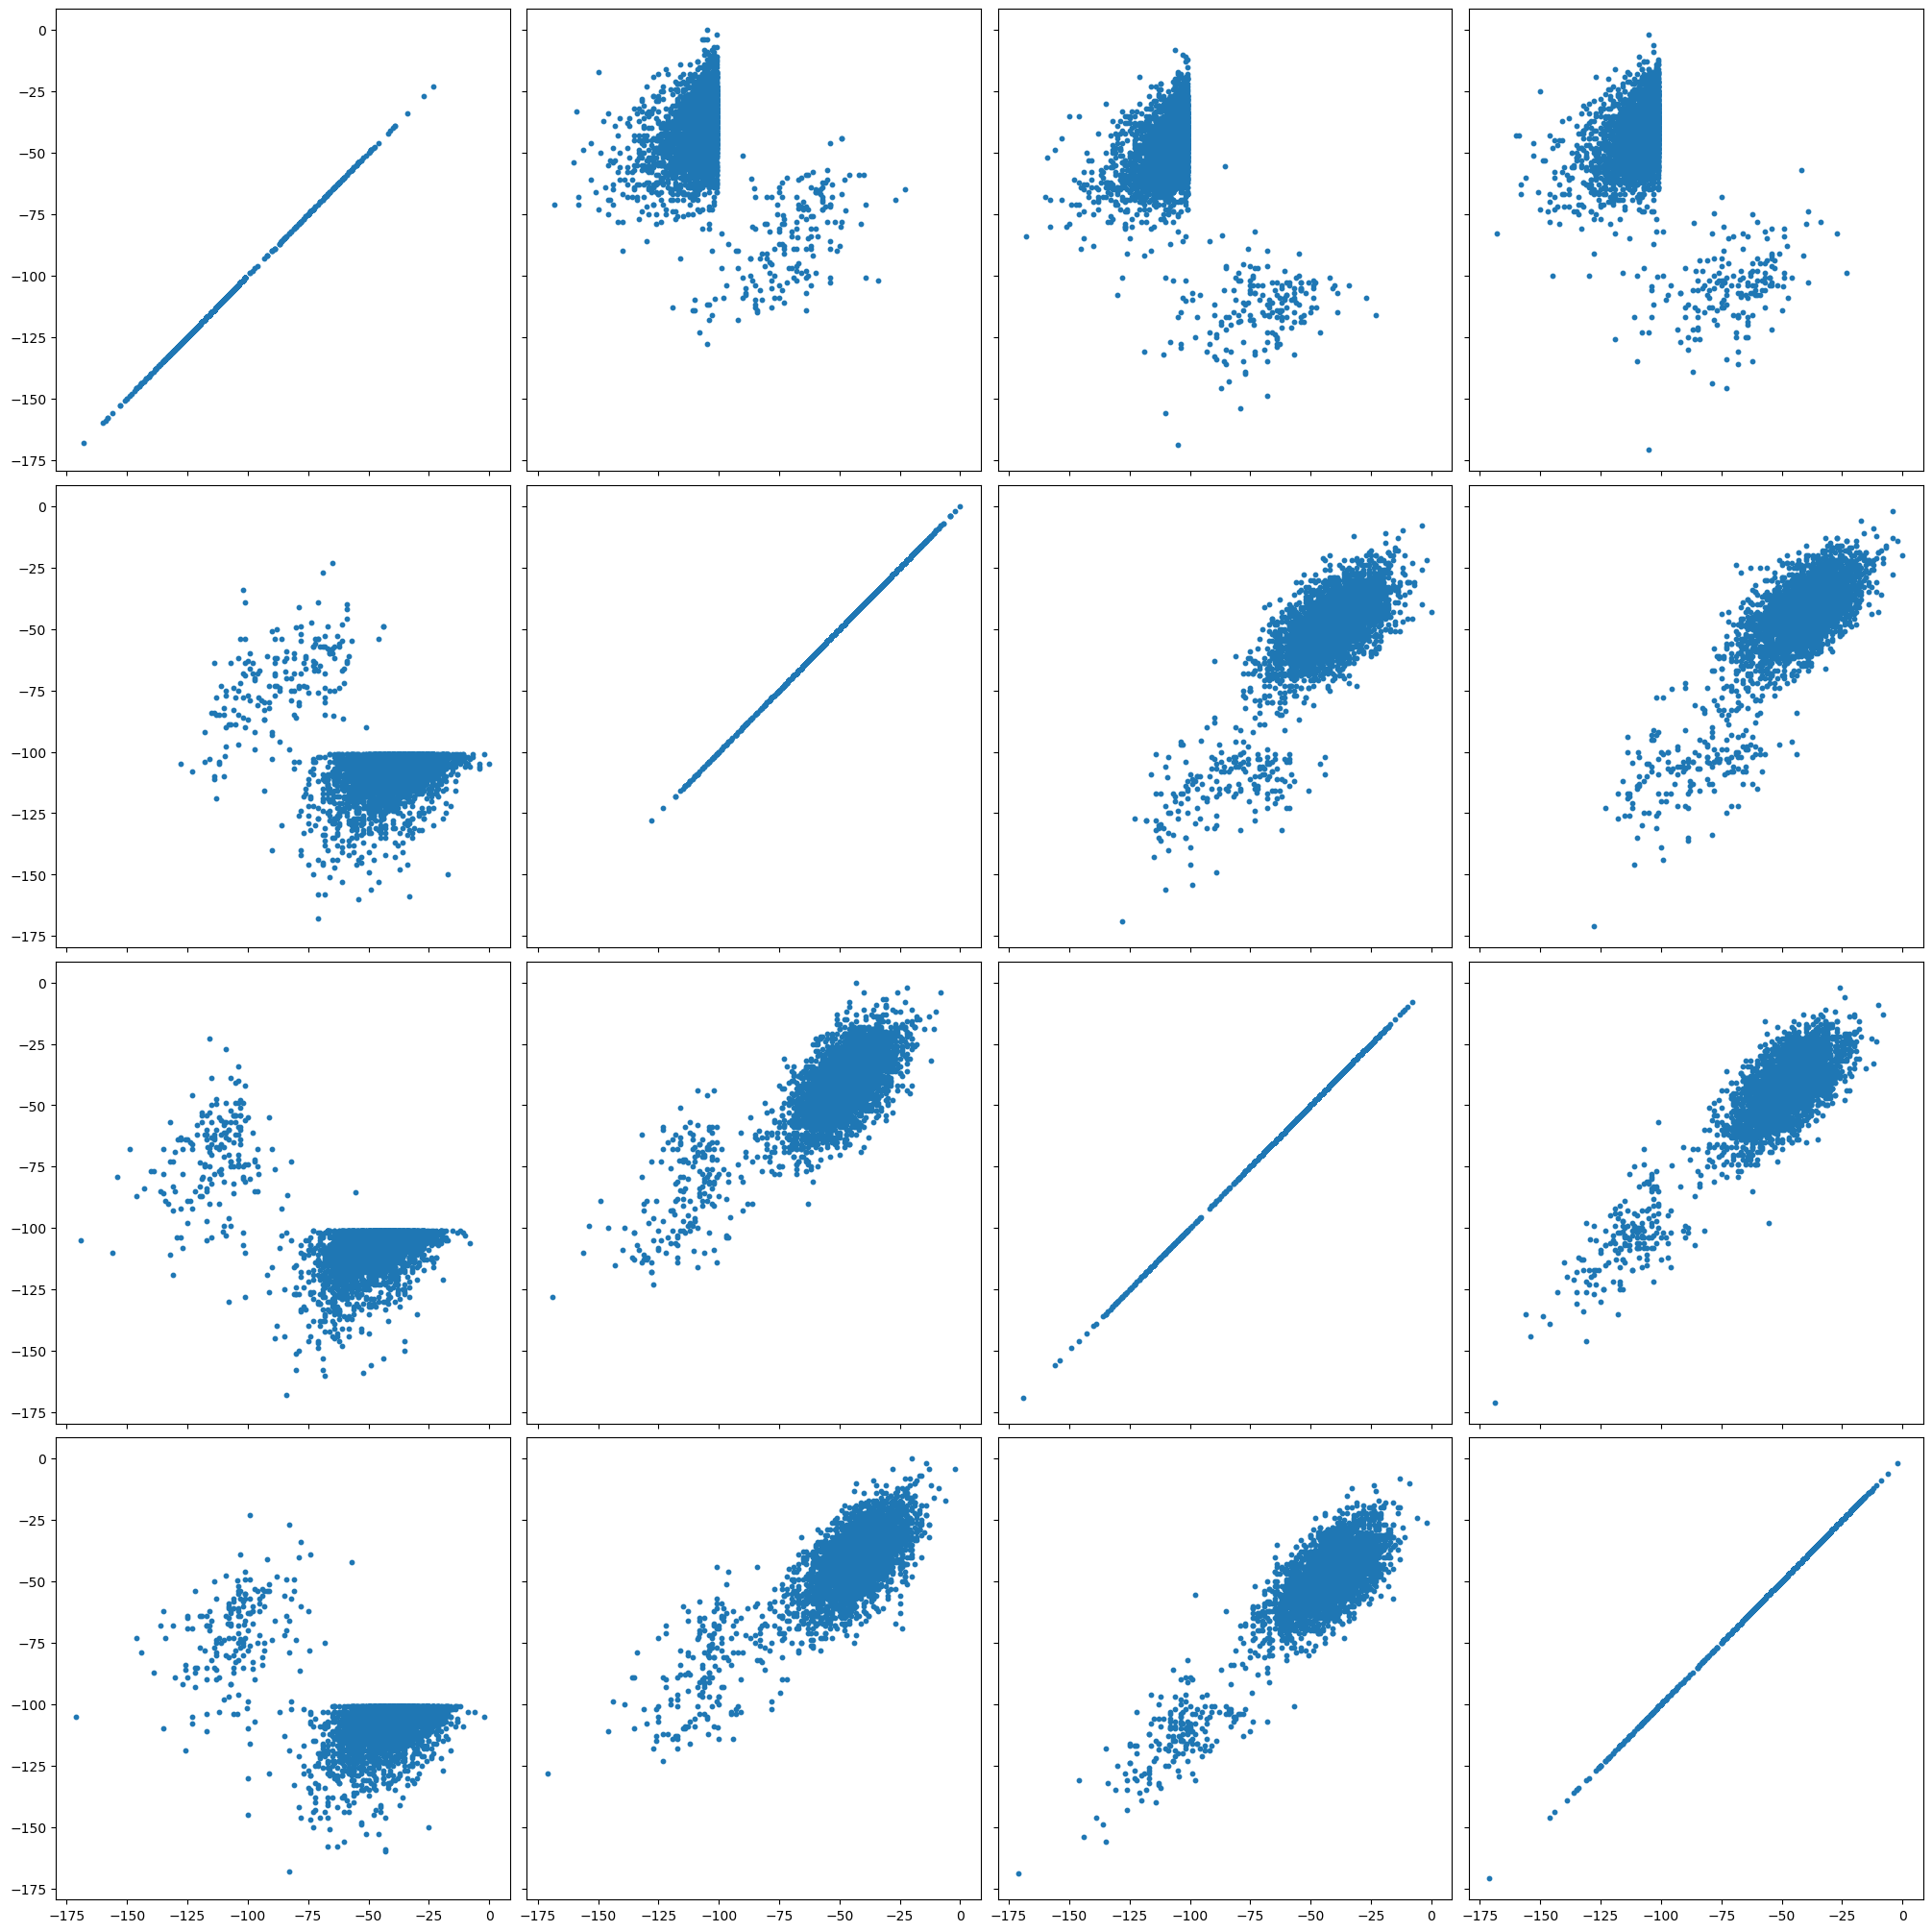

In [17]:
UnitMarksIndicator.plot_all_marks(marks)
